In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

In [ ]:
normalize = transforms.Normalize(
    mean=[0.4914, 0.4822, 0.4465],
    std=[0.247, 0.2435, 0.2616],
)

In [ ]:
def samplers(n, split_shuffle=True, val_size=0.1):
    if split_shuffle:
        idx = torch.randperm(n, generator=torch.Generator().manual_seed(0))
    else:
        idx = torch.arange(n)
    split_idx = int((1.0 - val_size) * n)
    train_sampler = SubsetRandomSampler(idx[:split_idx])
    val_sampler = SubsetRandomSampler(idx[split_idx:])
    return train_sampler, val_sampler

In [ ]:
def train_val_dataloader(root_dir='./cifar10', split_shuffle=True, val_size=0.1, batch_size=128):
    train_dataset = CIFAR10(root=root_dir, train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), normalize]))
    val_dataset = CIFAR10(root=root_dir, train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), normalize]))

    
    train_sampler, val_sampler = samplers(len(train_dataset), split_shuffle, val_size)
    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)
    val_dataloader = DataLoader(val_dataset, sampler=val_sampler, batch_size=batch_size)
    return train_dataloader, val_dataloader


In [ ]:
def test_dataloader(root_dir='./cifar10', batch_size=128):
    test_dataset = CIFAR10(root=root_dir, train=False, download=True, transform=transforms.Compose([transforms.ToTensor(), normalize]))
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size)
    return test_dataloader

In [ ]:
# For testing
class LeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out 

In [ ]:
def train_batch(model, x_batch, y_batch, loss_fn, optimizer):
    model.train()
    model.zero_grad()
    output = model(x_batch)
    loss = loss_fn(output, y_batch)
    loss.backward()
    optimizer.step()
    batch_loss = loss.cpu().item()
    with torch.no_grad():
        batch_acc_sum = (output.argmax(dim=1) == y_batch).sum().cpu().item()
    return batch_loss, batch_acc_sum


In [ ]:
def train_epoch(model, dataloader, loss_fn, optimizer):
    epoch_loss = 0.0
    epoch_acc = 0
    epoch_size = 0
    for i_batch, (X_batch, y_batch) in enumerate(dataloader):
        batch_loss, batch_acc_sum = train_batch(model, X_batch.to(model.device), y_batch.to(model.device), loss_fn, optimizer)
        epoch_size += len(X_batch)
        epoch_loss += batch_loss * len(X_batch)
        epoch_acc += batch_acc_sum
    epoch_loss /= epoch_size
    epoch_acc /= epoch_size
    return epoch_loss, epoch_acc


In [ ]:
def train_full(model, train_dataloader, val_dataloader, loss_fn, optimizer, n_epochs, callback=None):
    epochs = tqdm(range(n_epochs), desc='Epochs', leave=True)
    for i_epoch in epochs:
        epoch_loss, epoch_acc = train_epoch(model, train_dataloader, loss_fn, optimizer)
        if callback is not None:
            cb_dict = callback(model, val_dataloader, loss_fn, epoch_loss, epoch_acc)
            epochs.set_postfix(cb_dict)

In [ ]:
def evaluate(model, dataloader, loss_fn):
    model.eval()
    logits = []
    targets = []
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            output = model(X_batch.to(model.device)).cpu()
            logits.append(output)
            targets.append(y_batch)
    logits = torch.cat(logits)
    targets = torch.cat(targets)
    loss = loss_fn(logits, targets).item()
    acc = (logits.argmax(dim=1) == targets).sum().item() / len(targets)
    return loss, acc


In [ ]:
class CallBack:
    def __init__(self, eval_fn, name=None):
        self.eval_fn = eval_fn
        self.train_losses = []
        self.train_accs = []
        self.val_losses = []
        self.val_accs = []
    
    def last_info(self):
        return {'loss_train': f'{self.train_losses[-1]}',
                'acc_train': f'{self.train_accs[-1]}',
                'loss_val': f'{self.val_losses[-1]}',
                'acc_val': f'{self.val_accs[-1]}'}

    def __call__(self, model, val_dataloader, loss_fn,
                 epoch_loss=None, epoch_acc=None):
        self.train_losses.append(epoch_loss)
        self.train_accs.append(epoch_acc)
        loss_val, acc_val = self.eval_fn(model, val_dataloader, loss_fn)
        self.val_losses.append(loss_val)
        self.val_accs.append(acc_val)
        return self.last_info()

In [ ]:
#ResNet
#https://pytorch.org/vision/0.8/_modules/torchvision/models/resnet.html
#source: https://github.com/soapisnotfat/pytorch-cifar10/blob/master/models/ResNet.py
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, activation, stride=1):
        super(BasicBlock, self).__init__()
        self.activation = activation
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = self.activation(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.activation(out)
        return out

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, activation, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.activation = activation
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)


    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, self.activation, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.activation(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


In [ ]:
def ResNet18(activation):
    return ResNet(BasicBlock, [2, 2, 2, 2], activation)

In [ ]:
def pipeline(activation_set, optimizer_set, lr):
    if activation_set == 'ReLU':
        activation = F.relu
    elif activation_set == 'LeakyReLU':
        activation = F.leaky_relu
    model = ResNet18(activation)
    model.to(device)
    model.device = device
    loss_fn = nn.CrossEntropyLoss()
    if optimizer_set == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_set == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
    cb = CallBack(evaluate)
    train_full(model, train_dataloader, val_dataloader, loss_fn, optimizer, n_epochs=30, callback=cb)
    
    loss, acc = evaluate(model, val_dataloader, loss_fn)

    return acc
    

In [ ]:
%pip install optuna

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


In [ ]:
import optuna
optuna.logging.set_verbosity(optuna.logging.ERROR)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
train_dataloader, val_dataloader = train_val_dataloader()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
test_loader = test_dataloader()

Files already downloaded and verified


In [ ]:
device

device(type='cuda')

# TPE

In [ ]:
def objective(trial):

    lr = trial.suggest_float('lr', 1e-3, 1e-1, log=True)
    optimizer_set = trial.suggest_categorical('optimizer', ['Adam', 'SGD'])
    activation_set = trial.suggest_categorical('activation', ['ReLU', 'LeakyReLU'])    
    return pipeline(activation_set, optimizer_set, lr)

In [ ]:
%%time
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=12)

[I 2022-05-01 19:09:02,889] A new study created in memory with name: no-name-9e6dba09-9ad3-41bd-93ac-c02d0d87f1f8


[I 2022-05-01 19:36:34,644] Trial 0 finished with value: 0.6348 and parameters: {'lr': 0.0015945001845400104, 'optimizer': 'SGD', 'activation': 'ReLU'}. Best is trial 0 with value: 0.6348.


[I 2022-05-01 20:03:07,555] Trial 1 finished with value: 0.8374 and parameters: {'lr': 0.0022219643831163016, 'optimizer': 'Adam', 'activation': 'LeakyReLU'}. Best is trial 1 with value: 0.8374.


[I 2022-05-01 20:29:39,847] Trial 2 finished with value: 0.7936 and parameters: {'lr': 0.01060916159883671, 'optimizer': 'Adam', 'activation': 'LeakyReLU'}. Best is trial 1 with value: 0.8374.


[I 2022-05-01 20:55:56,495] Trial 3 finished with value: 0.7538 and parameters: {'lr': 0.009192022785404248, 'optimizer': 'SGD', 'activation': 'ReLU'}. Best is trial 1 with value: 0.8374.


[I 2022-05-01 21:22:31,347] Trial 4 finished with value: 0.8382 and parameters: {'lr': 0.001646079823086987, 'optimizer': 'Adam', 'activation': 'ReLU'}. Best is trial 4 with value: 0.8382.


[I 2022-05-01 21:48:45,276] Trial 5 finished with value: 0.7028 and parameters: {'lr': 0.004514413570023949, 'optimizer': 'SGD', 'activation': 'ReLU'}. Best is trial 4 with value: 0.8382.


[I 2022-05-01 22:15:19,047] Trial 6 finished with value: 0.7922 and parameters: {'lr': 0.008159975330871696, 'optimizer': 'Adam', 'activation': 'LeakyReLU'}. Best is trial 4 with value: 0.8382.


[I 2022-05-01 22:41:50,847] Trial 7 finished with value: 0.8198 and parameters: {'lr': 0.0023034515971294485, 'optimizer': 'Adam', 'activation': 'ReLU'}. Best is trial 4 with value: 0.8382.


[I 2022-05-01 23:08:19,046] Trial 8 finished with value: 0.8262 and parameters: {'lr': 0.003935089807036874, 'optimizer': 'Adam', 'activation': 'LeakyReLU'}. Best is trial 4 with value: 0.8382.


[I 2022-05-01 23:34:32,619] Trial 9 finished with value: 0.7398 and parameters: {'lr': 0.008515242186075859, 'optimizer': 'SGD', 'activation': 'ReLU'}. Best is trial 4 with value: 0.8382.


[I 2022-05-02 00:00:39,935] Trial 10 finished with value: 0.7714 and parameters: {'lr': 0.06235449381439291, 'optimizer': 'Adam', 'activation': 'ReLU'}. Best is trial 4 with value: 0.8382.


[I 2022-05-02 00:27:14,893] Trial 11 finished with value: 0.8416 and parameters: {'lr': 0.001118808219084845, 'optimizer': 'Adam', 'activation': 'LeakyReLU'}. Best is trial 11 with value: 0.8416.


CPU times: user 3h 46min 55s, sys: 1h 33min 28s, total: 5h 20min 24s
Wall time: 5h 18min 16s


<ipython-input-1-07d5f4f9f4d7>:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


<Figure size 1440x1296 with 0 Axes>

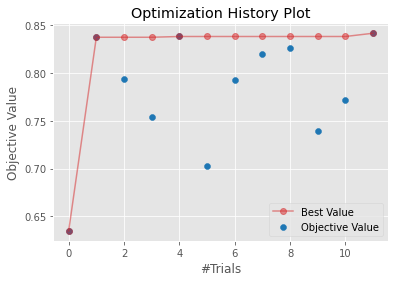

In [ ]:
plt.figure(figsize=(20, 18))
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.savefig('ResNet_TPE_HIST.pdf')

In [ ]:
print('ResNet, TPE, best trial:')
print(study.best_trial.params)
print('ResNet, TPE, best accuracy:')
print(study.best_value)
print('ResNet, TPE, best trial number')
print(study.best_trial.number)

ResNet, TPE, best trial:
{'lr': 0.001118808219084845, 'optimizer': 'Adam', 'activation': 'LeakyReLU'}
ResNet, TPE, best accuracy:
0.8416
ResNet, TPE, best trial number
11


<ipython-input-3-ae1d09c0b930>:2: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_contour(study, params=["lr", "optimizer", "activation"])
[W 2022-05-02 00:28:09,200] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


<Figure size 1440x1296 with 0 Axes>

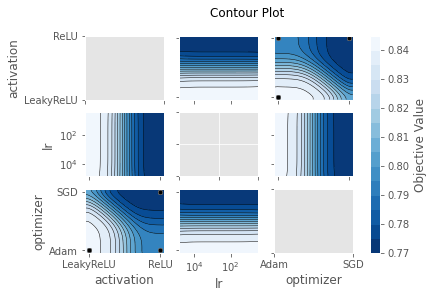

In [ ]:
plt.figure(figsize=(20, 18))
optuna.visualization.matplotlib.plot_contour(study, params=["lr", "optimizer", "activation"])
plt.savefig('ResNet_TPE_CP.pdf')

In [ ]:
def eval_test(study):
    lr = study.best_trial.params['lr']
    if study.best_trial.params['activation'] == 'ReLU':
        activation = F.relu
    elif study.best_trial.params['activation'] == 'LeakyReLU':
        activation = F.leaky_relu

    model = ResNet18(activation)
    model.to(device)
    model.device = device
    loss_fn = nn.CrossEntropyLoss()
    cb = CallBack(evaluate)

    if study.best_trial.params['optimizer'] == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif study.best_trial.params['optimizer'] == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
    train_full(model, train_dataloader, val_dataloader, loss_fn, optimizer, n_epochs=30, callback=cb)
    
    return evaluate(model, test_loader, loss_fn)

In [ ]:
loss, acc = eval_test(study)
print('ResNet, CMA-ES, accuracy on test:')
print(acc)


ResNet, CMA-ES, accuracy on test:
0.8286



There should be 'TPE'

# Random search

In [ ]:
%%time
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler())
study.optimize(objective, n_trials=12)

[I 2022-05-02 00:57:30,386] A new study created in memory with name: no-name-361d5d19-86fc-411c-afbe-aa56b0cce6fe


[I 2022-05-02 01:23:47,214] Trial 0 finished with value: 0.6978 and parameters: {'lr': 0.00431142821419278, 'optimizer': 'SGD', 'activation': 'LeakyReLU'}. Best is trial 0 with value: 0.6978.


[I 2022-05-02 01:50:03,634] Trial 1 finished with value: 0.8244 and parameters: {'lr': 0.04643364597670364, 'optimizer': 'SGD', 'activation': 'ReLU'}. Best is trial 1 with value: 0.8244.


[I 2022-05-02 02:16:20,134] Trial 2 finished with value: 0.8436 and parameters: {'lr': 0.09037681144995528, 'optimizer': 'SGD', 'activation': 'ReLU'}. Best is trial 2 with value: 0.8436.


[I 2022-05-02 02:43:01,639] Trial 3 finished with value: 0.8064 and parameters: {'lr': 0.010441703593505674, 'optimizer': 'Adam', 'activation': 'ReLU'}. Best is trial 2 with value: 0.8436.


[I 2022-05-02 03:09:43,455] Trial 4 finished with value: 0.7784 and parameters: {'lr': 0.07591820896628595, 'optimizer': 'Adam', 'activation': 'LeakyReLU'}. Best is trial 2 with value: 0.8436.


[I 2022-05-02 03:36:10,287] Trial 5 finished with value: 0.7072 and parameters: {'lr': 0.004698832128536679, 'optimizer': 'SGD', 'activation': 'LeakyReLU'}. Best is trial 2 with value: 0.8436.


[I 2022-05-02 04:02:36,781] Trial 6 finished with value: 0.7206 and parameters: {'lr': 0.006450300070756307, 'optimizer': 'SGD', 'activation': 'ReLU'}. Best is trial 2 with value: 0.8436.


[I 2022-05-02 04:29:00,475] Trial 7 finished with value: 0.8192 and parameters: {'lr': 0.03290061188833177, 'optimizer': 'SGD', 'activation': 'LeakyReLU'}. Best is trial 2 with value: 0.8436.


[I 2022-05-02 04:55:34,497] Trial 8 finished with value: 0.8016 and parameters: {'lr': 0.020350091598381387, 'optimizer': 'Adam', 'activation': 'ReLU'}. Best is trial 2 with value: 0.8436.


[I 2022-05-02 05:21:56,539] Trial 9 finished with value: 0.8336 and parameters: {'lr': 0.05416233817195137, 'optimizer': 'SGD', 'activation': 'ReLU'}. Best is trial 2 with value: 0.8436.


[I 2022-05-02 05:48:37,911] Trial 10 finished with value: 0.771 and parameters: {'lr': 0.04779266629202528, 'optimizer': 'Adam', 'activation': 'LeakyReLU'}. Best is trial 2 with value: 0.8436.


[I 2022-05-02 06:15:00,605] Trial 11 finished with value: 0.8314 and parameters: {'lr': 0.042501236456809324, 'optimizer': 'SGD', 'activation': 'LeakyReLU'}. Best is trial 2 with value: 0.8436.


CPU times: user 3h 47min 9s, sys: 1h 33min 28s, total: 5h 20min 38s
Wall time: 5h 17min 52s


<ipython-input-1-5884eb65fce0>:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


<Figure size 1440x1296 with 0 Axes>

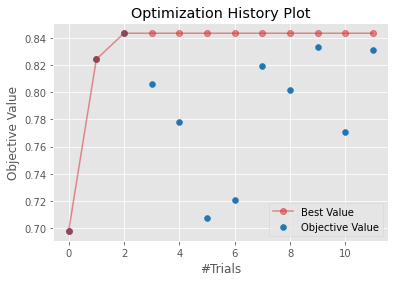

In [ ]:
plt.figure(figsize=(20, 18))
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.savefig('ResNet_RS_HIST.pdf')

In [ ]:
print('ResNet, RS, best trial:')
print(study.best_trial.params)
print('ResNet, RS, best accuracy:')
print(study.best_value)
print('ResNet, RS, best trial number')
print(study.best_trial.number)

ResNet, RS, best trial:
{'lr': 0.09037681144995528, 'optimizer': 'SGD', 'activation': 'ReLU'}
ResNet, RS, best accuracy:
0.8436
ResNet, RS, best trial number
2


<ipython-input-3-eeebbd579c89>:2: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_contour(study, params=["lr", "optimizer", "activation"])
[W 2022-05-02 06:15:33,632] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


<Figure size 1440x1296 with 0 Axes>

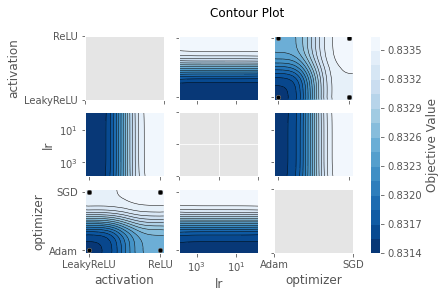

In [ ]:
plt.figure(figsize=(20, 18))
optuna.visualization.matplotlib.plot_contour(study, params=["lr", "optimizer", "activation"])
plt.savefig('ResNet_RS_CP.pdf')

In [ ]:
loss, acc = eval_test(study)
print('ResNet, RS, accuracy on test:')
print(acc)


ResNet, RS, accuracy on test:
0.8431


# Bayesian optimization

In [ ]:
%pip install scikit-optimize

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 100 kB 2.2 MB/s           
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


In [ ]:
from skopt import BayesSearchCV, gp_minimize
from skopt.plots import plot_objective, plot_convergence, plot_gaussian_process, plot_evaluations
from skopt.space import Real, Categorical, Integer

In [ ]:
space = [Categorical(['ReLU', 'LeakyReLU'], name='activation'),
         Categorical(['Adam', 'SGD'], name='optimizer'),
         Real(1e-3, 1e-1, 'log-uniform', name='lr')
]

In [ ]:
def objective(params):
    param_dict = {dim.name: val for dim, val in zip(space, params)}
    lr = param_dict['lr']
    if param_dict['activation'] == 'ReLU':
        activation = F.relu
    elif param_dict['activation'] == 'LeakyReLU':
        activation = F.leaky_relu
    model = ResNet18(activation)
    model.to(device)
    model.device = device
    loss_fn = nn.CrossEntropyLoss()
    cb = CallBack(evaluate)
    if param_dict['optimizer'] == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif param_dict['optimizer'] == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
    train_full(model, train_dataloader, val_dataloader, loss_fn, optimizer, n_epochs=30, callback=cb)
    
    loss, acc = evaluate(model, val_dataloader, loss_fn)
    return -acc

In [ ]:
%%time
res_gp = gp_minimize(objective, space, n_calls=12)
print('ResNet, BO, best params:')
print(f'activation: {res_gp.x[0]}, optimizer: {res_gp.x[1]}, lr: {res_gp.x[2]}')
print('ResNet, BO, best accuracy:')
print(res_gp.fun)


ResNet, BO, best params:
activation: LeakyReLU, optimizer: SGD, lr: 0.1
ResNet, BO, best accuracy:
-0.843
CPU times: user 3h 44min 42s, sys: 1h 32min 27s, total: 5h 17min 9s
Wall time: 5h 15min 10s


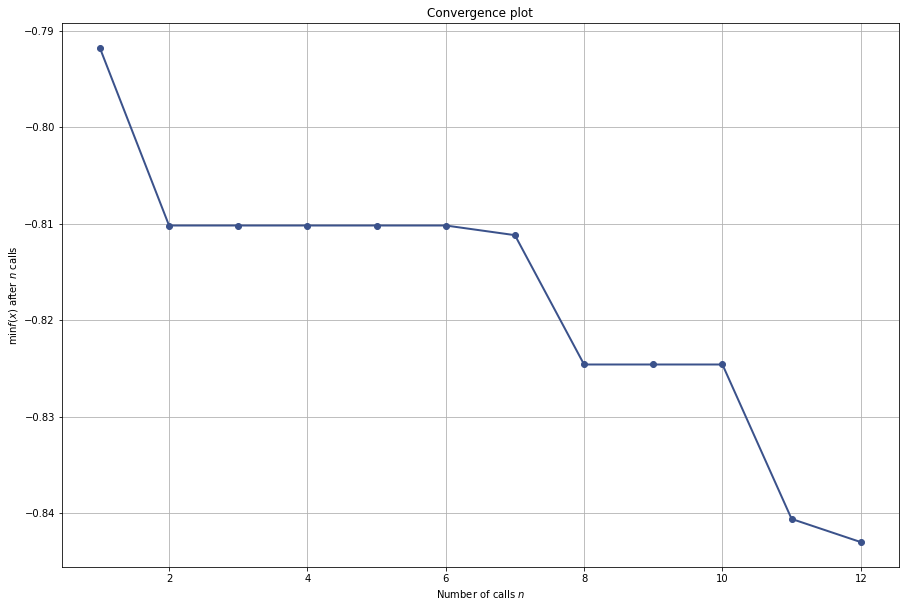

In [ ]:
plt.figure(figsize=(15, 10))
vis = plot_convergence(res_gp)
plt.savefig('ResNet_BO_HIST.pdf')

<Figure size 1440x1080 with 0 Axes>

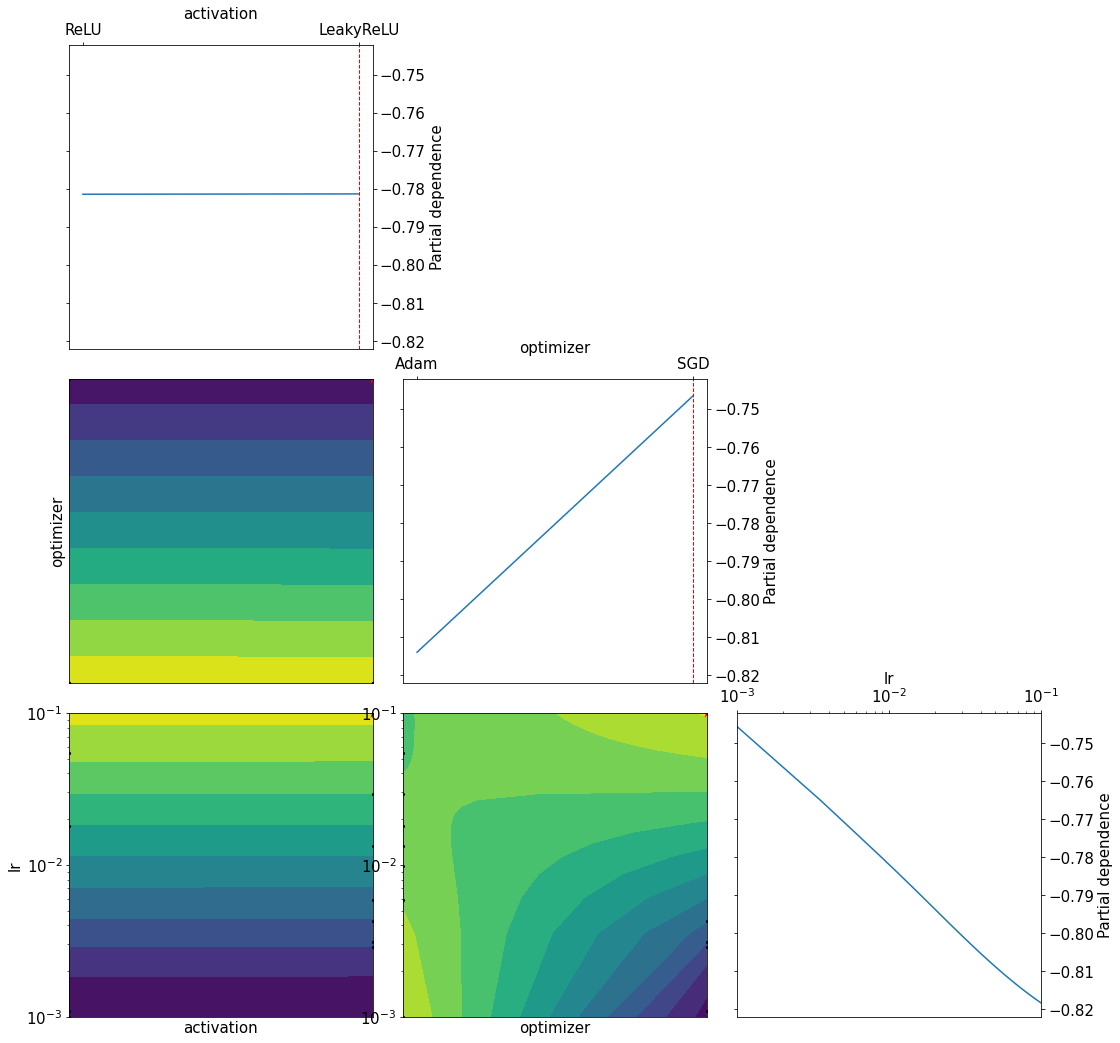

In [ ]:
plt.rc('font', size=15)
plt.figure(figsize=(20, 15))
plot_objective(res_gp, size=5)
plt.savefig(fname='GS_CP_BO.pdf')

In [ ]:
lr = res_gp.x[2]
if res_gp.x[0] == 'ReLU':
    activation = F.relu
elif res_gp.x[0] == 'LeakyReLU':
    activation = F.leaky_relu

model = ResNet18(activation)
model.to(device)
model.device = device
loss_fn = nn.CrossEntropyLoss()
cb = CallBack(evaluate)

if res_gp.x[1] == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
elif res_gp.x[1] == 'SGD':
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
train_full(model, train_dataloader, val_dataloader, loss_fn, optimizer, n_epochs=30, callback=cb)
    
loss, acc = evaluate(model, test_loader, loss_fn)
print('ResNet, BO, accuracy on test:')
print(acc)


ResNet, BO, accuracy on test:
0.8411
